In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from fredapi import Fred

from qreit.models import api_config
fred_key = api_config.fred_API


In [12]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

In [21]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    fig.show()
    return ts_ax, acf_ax, pacf_ax

In [9]:
fred = Fred(fred_key)
UMCSENT_series = fred.get_series('UMCSENT')

In [14]:
test_stationarity(UMCSENT_series.dropna())

Test Statistic                  -2.703042
p-value                          0.073513
#Lags Used                      19.000000
Number of Observations Used    568.000000
Critical Value (1%)             -3.441915
Critical Value (5%)             -2.866642
Critical Value (10%)            -2.569487
dtype: float64

/Users/marktblack/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


(<matplotlib.axes._subplots.AxesSubplot at 0x12c431ba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12bfa6278>)

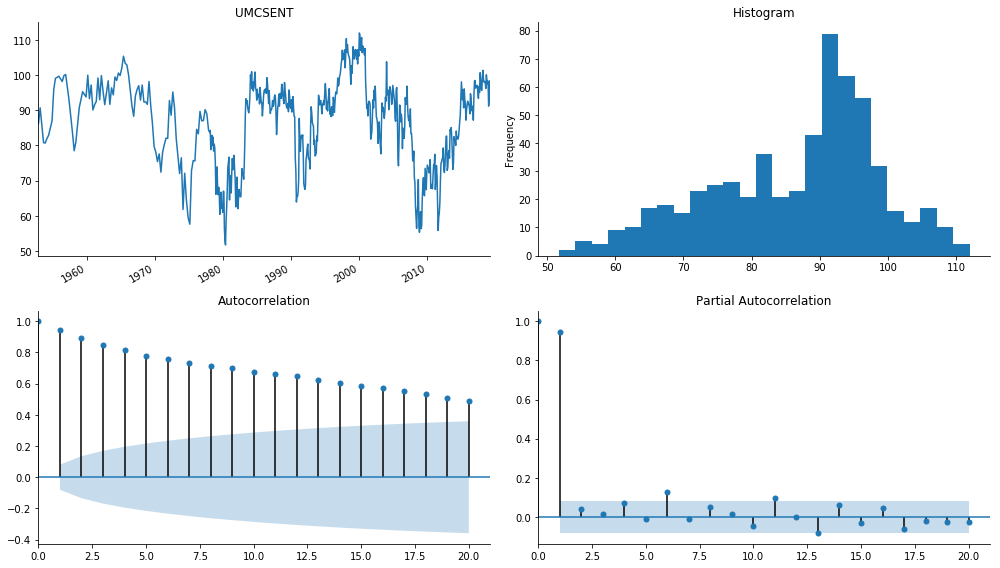

In [28]:
tsplot(UMCSENT_series.dropna(), 20, 'UMCSENT')